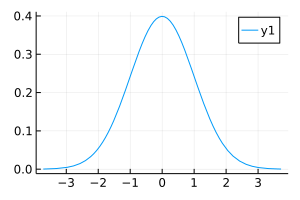

In [1]:
ENV["LINES"] = 200
ENV["COLUMNS"] = 200

using Distributions
using ForwardDiff
using Memoization
using RCall
using Roots
using StaticArrays
using StatsPlots
plot(Normal(); size=(300, 200))

In [2]:
x ⪅ y = x < y || x ≈ y
x ⪆ y = x > y || x ≈ y

@memoize function pval_exact(k, n, θ)
    bin = Binomial(n, θ)
    pk = pdf(bin, k)
    P = sum(pdf(bin, j) for j in support(bin) if pdf(bin, j) ⪅ pk; init = 0.0)
    min(1, P)
end

@memoize function pval_dos(k, n, θ)
    bin = Binomial(n, θ)
    min(1, 2cdf(bin, k), 2ccdf(bin, k-1))
end

pval_dos (generic function with 1 method)

In [3]:
x ⪅ y = x < y || x ≈ y
x ⪆ y = x > y || x ≈ y

@memoize function pval_exact(dist, k)
    pk = pdf(dist, k)
    P = sum(pdf(dist, j) for j in support(dist) if pdf(dist, j) ⪅ pk; init = 0.0)
    min(1, P)
end

@memoize function pval_dos(dist, k)
    min(1, 2cdf(dist, k), 2ccdf(dist, k-1))
end

pval_dos (generic function with 2 methods)

In [4]:
@memoize function pval_exact2(k, n, θ)
    bin = Binomial(n, θ)
    pk = pdf(bin, k)
    if k ⪅ mean(bin)
        a = k
        b = n + 1
        while a ≤ b
            if pdf(bin, b - 1) ⪅ pk
                b -= 1
            else
                break
            end
        end
    else
        b = k
        a = -1
        while a ≤ b
            if pdf(bin, a + 1) ⪅ pk
                a += 1
            else
                break
            end
        end
    end
    P = min(1, a < b ? cdf(bin, a) + ccdf(bin, b-1) : 1.0)
end

pval_exact2 (generic function with 1 method)

In [5]:
bin = Binomial(10, 0.4)
[(k = k, p = pdf(bin, k)) for k in 0:10]

11-element Vector{NamedTuple{(:k, :p), Tuple{Int64, Float64}}}:
 (k = 0, p = 0.0060466176)
 (k = 1, p = 0.04031078400000004)
 (k = 2, p = 0.12093235199999994)
 (k = 3, p = 0.2149908480000006)
 (k = 4, p = 0.2508226560000002)
 (k = 5, p = 0.20065812480000034)
 (k = 6, p = 0.11147673600000013)
 (k = 7, p = 0.04246732800000012)
 (k = 8, p = 0.010616832)
 (k = 9, p = 0.0015728640000000028)
 (k = 10, p = 0.00010485760000000014)

In [6]:
[(k = k, P = pval_exact(k, params(bin)...)) for k in -1:11]

13-element Vector{NamedTuple{(:k, :P), Tuple{Int64, Float64}}}:
 (k = -1, P = 0.0)
 (k = 0, P = 0.007724339200000003)
 (k = 1, P = 0.058651955200000036)
 (k = 2, P = 0.3335283712000003)
 (k = 3, P = 0.749177344000001)
 (k = 4, P = 1.0)
 (k = 5, P = 0.5341864960000006)
 (k = 6, P = 0.2125960192000003)
 (k = 7, P = 0.10111928320000015)
 (k = 8, P = 0.018341171200000003)
 (k = 9, P = 0.0016777216000000029)
 (k = 10, P = 0.00010485760000000014)
 (k = 11, P = 0.0)

In [7]:
[(k = k, ΔP = pval_exact2(k, params(bin)...) - pval_exact(k, params(bin)...)) for k in -1:11]

13-element Vector{NamedTuple{(:k, :ΔP), Tuple{Int64, Float64}}}:
 (k = -1, ΔP = 0.0)
 (k = 0, ΔP = 8.673617379884035e-19)
 (k = 1, ΔP = -1.3877787807814457e-17)
 (k = 2, ΔP = -1.6653345369377348e-16)
 (k = 3, ΔP = -7.771561172376096e-16)
 (k = 4, ΔP = 0.0)
 (k = 5, ΔP = -3.3306690738754696e-16)
 (k = 6, ΔP = -8.326672684688674e-17)
 (k = 7, ΔP = -8.326672684688674e-17)
 (k = 8, ΔP = 0.0)
 (k = 9, ΔP = -8.673617379884035e-19)
 (k = 10, ΔP = 1.3552527156068805e-20)
 (k = 11, ΔP = 0.0)

In [8]:
d(k, n, θ) = k/θ - (n - k)/(1 - θ)
dpdf(bin, k) = d(k, params(bin)...) * pdf(bin, k)

@memoize function phi(k, n, θ, α=0.05)
    bin = Binomial(n, θ)
    m = mean(bin)
    pk = pdf(bin, k)
    if k ⪅ m
        a = k
        b = n + 1
        while a ≤ b
            if pdf(bin, b - 1) ⪅ pk
                b -= 1
            else
                break
            end
        end
    else
        b = k
        a = -1
        while a ≤ b
            if pdf(bin, a + 1) ⪅ pk
                a += 1
            else
                break
            end
        end
    end

    P1 = a < b ? cdf(bin, a) + ccdf(bin, b-1) : 1.0
    P1 ⪅ α && return 1.0

    P0 = k ⪅ m ? pval_exact(k-1, n, θ) : pval_exact(k+1, n, θ)
    P0 ⪆ α && return 0.0
    
    a == b && return (α - P0)/(P1 - P0)
    
    dpdf(bin, j) = ForwardDiff.derivative(θ -> pdf(Binomial(n, θ), j), θ)
    M = @SMatrix [
        pdf(bin, a)  pdf(bin, b)
        dpdf(bin, a) dpdf(bin, b)
    ]
    y1 = max(0, α - P0)
    y2 = -sum(dpdf(bin, j) for j in 0:a-1; init=0.0) - sum(dpdf(bin, j) for j in b+1:n; init=0.0)
    y = @SVector [y1, y2]
    ra, rb = M \ y
    #(0 ≤ ra ⪅ 1 && 0 ≤ rb ⪅ 1) || 
    println("k = $k,  a = $a,  b = $b\nM = $M,  y = $y\nra = $ra,  rb = $rb")
    return k == a ? ra : rb
end

phi (generic function with 2 methods)

In [9]:
bin = Binomial(10, 0.3)
[(k = k, P = pval_exact(k, params(bin)...), phi = phi(k, params(bin)...)) for k in 0:10]

k = 1,  a = 1,  b = 5
M = [0.12106082100000018 0.10291934520000003; -1.1529602000000017 0.9801842400000004],  y = [0.011160396699999985, -0.3316021099999997]
ra = 0.18989883708949853,  rb = -0.11493380959637109
k = 6,  a = 0,  b = 6
M = [0.028247524900000005 0.03675690899999997; -0.4035360700000001 0.5250986999999995],  y = [0.039407921599999986, -0.21003948000000033]
ra = 0.9577951588954967,  rb = 0.33606141909266624


11-element Vector{NamedTuple{(:k, :P, :phi), Tuple{Int64, Float64, Float64}}}:
 (k = 0, P = 0.03883960330000002, phi = 1.0)
 (k = 1, P = 0.2995766785000002, phi = 0.18989883708949853)
 (k = 2, P = 0.733172068, phi = 0.0)
 (k = 3, P = 1.0, phi = 0.0)
 (k = 4, P = 0.4996976275000003, phi = 0.0)
 (k = 5, P = 0.1785158575, phi = 0.0)
 (k = 6, P = 0.0755965123, phi = 0.33606141909266624)
 (k = 7, P = 0.010592078400000015, phi = 1.0)
 (k = 8, P = 0.0015903863999999985, phi = 1.0)
 (k = 9, P = 0.00014368590000000015, phi = 1.0)
 (k = 10, P = 5.904899999999995e-6, phi = 1.0)

In [10]:
bin = Binomial(10, 0.3)
[(k = k, P = pval_exact(k, params(bin)...), phi = phi(k, params(bin)...)) for k in 0:10]

11-element Vector{NamedTuple{(:k, :P, :phi), Tuple{Int64, Float64, Float64}}}:
 (k = 0, P = 0.03883960330000002, phi = 1.0)
 (k = 1, P = 0.2995766785000002, phi = 0.18989883708949853)
 (k = 2, P = 0.733172068, phi = 0.0)
 (k = 3, P = 1.0, phi = 0.0)
 (k = 4, P = 0.4996976275000003, phi = 0.0)
 (k = 5, P = 0.1785158575, phi = 0.0)
 (k = 6, P = 0.0755965123, phi = 0.33606141909266624)
 (k = 7, P = 0.010592078400000015, phi = 1.0)
 (k = 8, P = 0.0015903863999999985, phi = 1.0)
 (k = 9, P = 0.00014368590000000015, phi = 1.0)
 (k = 10, P = 5.904899999999995e-6, phi = 1.0)

In [11]:
dpdf(bin::Binomial, j) = ForwardDiff.derivative(θ -> pdf(Binomial(ntrials(bin), θ), j), succprob(bin))

dpdf (generic function with 2 methods)

In [12]:
bin = Binomial(10, 1/3)
[(k = k, dpdf = dpdf(bin, k)) for k in -1:11]

13-element Vector{NamedTuple{(:k, :dpdf), Tuple{Int64, Float64}}}:
 (k = -1, dpdf = 0.0)
 (k = 0, dpdf = -0.26012294873748926)
 (k = 1, dpdf = -0.9104303205812133)
 (k = 2, dpdf = -1.1705532693187013)
 (k = 3, dpdf = -0.39018442310623436)
 (k = 4, dpdf = 0.6828227404359101)
 (k = 5, dpdf = 1.0242341106538637)
 (k = 6, dpdf = 0.6828227404359102)
 (k = 7, dpdf = 0.2682517908855366)
 (k = 8, dpdf = 0.0640146319158664)
 (k = 9, dpdf = 0.00863689478229946)
 (k = 10, dpdf = 0.000508052634252908)
 (k = 11, dpdf = 0.0)

In [13]:
dpdf2(fnh::FisherNoncentralHypergeometric, a) = ForwardDiff.derivative(t -> pdf(FisherNoncentralHypergeometric(params(fnh)[1:3]..., exp(t)), a), log(params(fnh)[4]))

dpdf2 (generic function with 1 method)

In [14]:
fnh = FisherNoncentralHypergeometric(11, 12, 10, 1.0)
@show mean(fnh)
[(a = a, dpdf = dpdf2(fnh, a)) for a in support(fnh)]

mean(fnh) = 4.782608695652174


11-element Vector{NamedTuple{(:a, :dpdf), Tuple{Int64, Float64}}}:
 (a = 0, dpdf = -0.0002759038149136881)
 (a = 1, dpdf = -0.008001210632496956)
 (a = 2, dpdf = -0.06621691557928515)
 (a = 3, dpdf = -0.2036170154063018)
 (a = 4, dpdf = -0.2085832840747482)
 (a = 5, dpdf = 0.06952776135824942)
 (a = 6, dpdf = 0.2433471647538729)
 (a = 7, dpdf = 0.14071094560598094)
 (a = 8, dpdf = 0.03062532345541938)
 (a = 9, dpdf = 0.0024329700042388866)
 (a = 10, dpdf = 5.0164329984306945e-5)

In [15]:
dpdf(fnh::FisherNoncentralHypergeometric, a) = ForwardDiff.derivative(ω -> pdf(FisherNoncentralHypergeometric(params(fnh)[1:3]..., ω), a), params(fnh)[4])

dpdf (generic function with 3 methods)

In [16]:
fnh = FisherNoncentralHypergeometric(11, 12, 10, 1.0)
@show mean(fnh)
[(a = a, dpdf = dpdf(fnh, a)) for a in support(fnh)]

mean(fnh) = 4.782608695652174


11-element Vector{NamedTuple{(:a, :dpdf), Tuple{Int64, Float64}}}:
 (a = 0, dpdf = -0.0002759038149136881)
 (a = 1, dpdf = -0.008001210632496956)
 (a = 2, dpdf = -0.06621691557928515)
 (a = 3, dpdf = -0.2036170154063018)
 (a = 4, dpdf = -0.2085832840747482)
 (a = 5, dpdf = 0.06952776135824942)
 (a = 6, dpdf = 0.2433471647538729)
 (a = 7, dpdf = 0.14071094560598094)
 (a = 8, dpdf = 0.03062532345541938)
 (a = 9, dpdf = 0.0024329700042388866)
 (a = 10, dpdf = 5.0164329984306945e-5)

In [17]:
function calcumpu(Dist, np, θ, α = 0.05)
    dist = Dist(np..., θ)
    supp = support(dist)
    pmf(x) = pdf(dist, x)
    dpmf(x) = ForwardDiff.derivative(θ -> pdf(Dist(np..., θ), x), θ)
    phi = Matrix{Union{Float64, Missing}}(undef, length(supp), length(supp))
    phi .= missing
    for i in eachindex(supp)
        a = supp[i]
        Ptmp = cdf(dist, a - 1)
        Ptmp ⪅ α || break
        P0 = Ptmp
        j = lastindex(supp)
        b = supp[j]
        while a < b
            Ptmp = P0 + pdf(dist, b)
            Ptmp ⪅ α || break
            P0 = Ptmp
            j -= 1
            b = supp[j]
        end
        @show P0, a, b
    end
    phi, supp
end

calcumpu (generic function with 2 methods)

In [18]:
calcumpu(Binomial, 10, 0.3)

(P0, a, b) = (0.04734898739999999, 0, 5)
(P0, a, b) = (0.038839603300000004, 1, 6)


(Union{Missing, Float64}[missing missing … missing missing; missing missing … missing missing; … ; missing missing … missing missing; missing missing … missing missing], 0:10)

In [19]:
function calcumpu(Dist, np, θ, α = 0.05)
    dist = Dist(np..., θ)
    s = support(dist)
    pmf(x) = pdf(dist, x)
    dpmf(x) = ForwardDiff.derivative(θ -> pdf(Dist(np..., θ), x), θ)
    @show dpmf.(s)
    R = Matrix{Union{Float64, Missing}}(undef, length(s), length(s))
    R .= missing
    for i in eachindex(s)
        Ptmp = cdf(dist, s[i] - 1)
        @show Ptmp
        Ptmp > α && continue
        P0 = Ptmp
        Pi = P0
        j = lastindex(s)
        Pj = 0.0
        while i < j
            Ptmp = P0 + pdf(dist, s[j])
            Ptmp ⪅ α || break
            P0 = Ptmp
            Pj += pdf(dist, s[j])
            j -= 1
        end
        dP0 = sum(dpmf(s[k]) for k in 1:i-1; init=0.0) + sum(dpmf(s[k]) for k in j+1:length(s); init=0.0)
        @show P0 ≈ sum(pmf(s[k]) for k in 1:i-1; init=0.0) + sum(pmf(k) for k in j+1:length(s); init=0.0)
        @show P0, Pi, Pj, dP0, s[i], s[j]
        M = @SMatrix [
             pmf(s[i])  pmf(s[j])
            dpmf(s[i]) dpmf(s[j])
        ]
        y = @SVector [max(0, α - P0), -dP0]
        @show M
        @show y
        ri, rj = M \ y
        R[i, :] .= 0
        R[i, 1:i-1] .= 1
        R[i, j+1:end] .= 1
        R[i, i] = ri
        R[i, j] = rj
        #@show ri*pmf(s[i]) + rj*pmf(s[j]) + P0
        #@show ri*dpmf(s[i]) + rj*dpmf(s[j]) + dP0
    end
    R, s
end

calcumpu (generic function with 2 methods)

In [20]:
R, s = calcumpu(Binomial, 10, 0.1)
@show s
R

dpmf.(s) = [-3.8742048899999992, 0.0, 2.15233605, 1.2754584000000038, 0.37200870000000086, 0.06613488000000013, 0.0076545000000000085, 0.0005832000000000034, 2.8350000000000018e-5, 8.000000000000024e-7, 1.0000000000000032e-8]
Ptmp = 0.0
P0 ≈ sum((pmf(s[k]) for k = 1:i - 1); init = 0.0) + sum((pmf(k) for k = j + 1:length(s)); init = 0.0) = false
(P0, Pi, Pj, dP0, s[i], s[j]) = (0.012795198400000029, 0.0, 0.012795198400000029, 0.446410440000001, 0, 3)
M = [0.34867844009999993 0.05739562800000017; -3.8742048899999992 1.2754584000000038]
y = [0.037204801599999976, -0.446410440000001]
Ptmp = 0.3486784401000003
Ptmp = 0.7360989290999997
Ptmp = 0.9298091735999999
Ptmp = 0.9872048016
Ptmp = 0.9983650626
Ptmp = 0.9998530974
Ptmp = 0.9999908784
Ptmp = 0.9999996264
Ptmp = 0.9999999909
Ptmp = 0.9999999999
s = 0:10


11×11 Matrix{Union{Missing, Float64}}:
 0.109544  0.0       0.0       -0.0172611  1.0       1.0       1.0       1.0       1.0       1.0       1.0
  missing   missing   missing    missing    missing   missing   missing   missing   missing   missing   missing
  missing   missing   missing    missing    missing   missing   missing   missing   missing   missing   missing
  missing   missing   missing    missing    missing   missing   missing   missing   missing   missing   missing
  missing   missing   missing    missing    missing   missing   missing   missing   missing   missing   missing
  missing   missing   missing    missing    missing   missing   missing   missing   missing   missing   missing
  missing   missing   missing    missing    missing   missing   missing   missing   missing   missing   missing
  missing   missing   missing    missing    missing   missing   missing   missing   missing   missing   missing
  missing   missing   missing    missing    missing   missing   missin

In [21]:
@show rj = (0.05 - ccdf(Binomial(10, 0.1), 3))/pdf(Binomial(10, 0.1), 3)
r = [zeros(3); rj; ones(7)]
@show rj * pdf(Binomial(10, 0.1), 3) + ccdf(Binomial(10, 0.1), 3)
@show 10 * 0.01 * 0.05
sum((0:10) .* vec(r) .* pdf.(Binomial(10, 0.1), 0:10))

rj = (0.05 - ccdf(Binomial(10, 0.1), 3)) / pdf(Binomial(10, 0.1), 3) = 0.6482166481391209
rj * pdf(Binomial(10, 0.1), 3) + ccdf(Binomial(10, 0.1), 3) = 0.05
10 * 0.01 * 0.05 = 0.005000000000000001


0.1645865428000001

In [22]:
ccdf(Binomial(10, 0.1), 3)

0.01279519840000001

In [23]:
pdf(Binomial(10, 0.1), 3)

0.05739562800000017

In [24]:
@show 10 * 0.1 * 0.05
[sum((0:10) .* vec(r) .* pdf.(Binomial(10, 0.1), 0:10)) for r in eachrow(R)]

10 * 0.1 * 0.05 = 0.05


11-element Vector{Union{Missing, Float64}}:
 0.05
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing

In [25]:
R, s = calcumpu(Binomial, 10, 0.2)
@show s
R

dpmf.(s) = [-1.34217728, -1.6777216000000021, 0.0, 1.258291200000003, 1.1010048000000006, 0.49545216000000025, 0.13762560000000026, 0.02457600000000004, 0.0027648000000000017, 0.00017920000000000032, 5.120000000000002e-6]
Ptmp = 0.0
P0 ≈ sum((pmf(s[k]) for k = 1:i - 1); init = 0.0) + sum((pmf(k) for k = j + 1:length(s)); init = 0.0) = false
(P0, Pi, Pj, dP0, s[i], s[j]) = (0.03279349760000003, 0.0, 0.03279349760000003, 0.6606028800000006, 0, 4)
M = [0.1073741824 0.08808038400000004; -1.34217728 1.1010048000000006]
y = [0.017206502399999976, -0.6606028800000006]
Ptmp = 0.10737418240000009
Ptmp = 0.37580963840000037
Ptmp = 0.6777995263999997
Ptmp = 0.8791261183999999
Ptmp = 0.9672065024000001
Ptmp = 0.9936306176
Ptmp = 0.9991356416
Ptmp = 0.9999220736000001
Ptmp = 0.9999958016
Ptmp = 0.9999998976
s = 0:10


11×11 Matrix{Union{Missing, Float64}}:
 0.326218  0.0       0.0       0.0       -0.202325  1.0       1.0       1.0       1.0       1.0       1.0
  missing   missing   missing   missing    missing   missing   missing   missing   missing   missing   missing
  missing   missing   missing   missing    missing   missing   missing   missing   missing   missing   missing
  missing   missing   missing   missing    missing   missing   missing   missing   missing   missing   missing
  missing   missing   missing   missing    missing   missing   missing   missing   missing   missing   missing
  missing   missing   missing   missing    missing   missing   missing   missing   missing   missing   missing
  missing   missing   missing   missing    missing   missing   missing   missing   missing   missing   missing
  missing   missing   missing   missing    missing   missing   missing   missing   missing   missing   missing
  missing   missing   missing   missing    missing   missing   missing   missi

In [26]:
@show 10 * 0.2 * 0.05
[sum((0:10) .* vec(r) .* pdf.(Binomial(10, 0.2), 0:10)) for r in eachrow(R)]

10 * 0.2 * 0.05 = 0.1


11-element Vector{Union{Missing, Float64}}:
 0.10000000000000002
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing

In [27]:
R, s = calcumpu(Binomial, 10, 0.3)
@show s
R

dpmf.(s) = [-0.4035360700000001, -1.1529602000000017, -1.1117830499999994, 0.0, 0.9529569000000008, 0.9801842400000004, 0.5250986999999995, 0.17146080000000036, 0.034445249999999955, 0.0039366000000000045, 0.00019682999999999983]
Ptmp = 0.0
P0 ≈ sum((pmf(s[k]) for k = 1:i - 1); init = 0.0) + sum((pmf(k) for k = j + 1:length(s)); init = 0.0) = false
(P0, Pi, Pj, dP0, s[i], s[j]) = (0.04734898739999999, 0.0, 0.04734898739999999, 0.7351381799999998, 0, 5)
M = [0.028247524900000005 0.10291934520000003; -0.4035360700000001 0.9801842400000004]
y = [0.002651012600000016, -0.7351381799999998]
Ptmp = 0.028247524899999987
P0 ≈ sum((pmf(s[k]) for k = 1:i - 1); init = 0.0) + sum((pmf(k) for k = j + 1:length(s)); init = 0.0) = false
(P0, Pi, Pj, dP0, s[i], s[j]) = (0.038839603300000004, 0.028247524899999987, 0.010592078400000017, -0.19349658999999975, 1, 6)
M = [0.12106082100000018 0.03675690899999997; -1.1529602000000017 0.5250986999999995]
y = [0.011160396699999998, 0.19349658999999975]
Ptmp = 0.

11×11 Matrix{Union{Missing, Float64}}:
 1.13058    0.0        0.0       0.0       0.0       -0.284545  1.0       1.0       1.0       1.0       1.0
 1.0       -0.0118174  0.0       0.0       0.0        0.0       0.342548  1.0       1.0       1.0       1.0
  missing    missing    missing   missing   missing    missing   missing   missing   missing   missing   missing
  missing    missing    missing   missing   missing    missing   missing   missing   missing   missing   missing
  missing    missing    missing   missing   missing    missing   missing   missing   missing   missing   missing
  missing    missing    missing   missing   missing    missing   missing   missing   missing   missing   missing
  missing    missing    missing   missing   missing    missing   missing   missing   missing   missing   missing
  missing    missing    missing   missing   missing    missing   missing   missing   missing   missing   missing
  missing    missing    missing   missing   missing    missing   mi

In [28]:
@show 10 * 0.3 * 0.05
[sum((0:10) .* vec(r) .* pdf.(Binomial(10, 0.3), 0:10)) for r in eachrow(R)]

10 * 0.3 * 0.05 = 0.15000000000000002


11-element Vector{Union{Missing, Float64}}:
 0.15000000000000002
 0.15000000000000008
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing

In [29]:
R, s = calcumpu(Binomial, 10, 0.4)
@show s
R

dpmf.(s) = [-0.10077696000000001, -0.5038848000000005, -1.0077695999999996, -0.8957952000000028, 0.0, 0.8360755200000013, 0.9289728000000009, 0.5308416000000015, 0.1769472, 0.032768000000000054, 0.0026214400000000035]
Ptmp = 0.0
P0 ≈ sum((pmf(s[k]) for k = 1:i - 1); init = 0.0) + sum((pmf(k) for k = j + 1:length(s)); init = 0.0) = false
(P0, Pi, Pj, dP0, s[i], s[j]) = (0.012294553600000003, 0.0, 0.012294553600000003, 0.21233664000000005, 0, 7)
M = [0.0060466176 0.04246732800000012; -0.10077696000000001 0.5308416000000015]
y = [0.0377054464, -0.21233664000000005]
Ptmp = 0.006046617600000002
P0 ≈ sum((pmf(s[k]) for k = 1:i - 1); init = 0.0) + sum((pmf(k) for k = j + 1:length(s)); init = 0.0) = false
(P0, Pi, Pj, dP0, s[i], s[j]) = (0.018341171200000006, 0.006046617600000002, 0.012294553600000003, 0.11155968000000004, 1, 7)
M = [0.04031078400000004 0.04246732800000012; -0.5038848000000005 0.5308416000000015]
y = [0.0316588288, -0.11155968000000004]
Ptmp = 0.04635740160000002
P0 ≈ sum((pmf

11×11 Matrix{Union{Missing, Float64}}:
 3.87648   0.0        0.0       0.0       0.0       0.0       0.0       0.335925  1.0       1.0       1.0
 1.0       0.503384   0.0       0.0       0.0       0.0       0.0       0.267665  1.0       1.0       1.0
 1.0       1.0       -0.177463  0.0       0.0       0.0       0.0       0.0       2.20648   1.0       1.0
  missing   missing    missing   missing   missing   missing   missing   missing   missing   missing   missing
  missing   missing    missing   missing   missing   missing   missing   missing   missing   missing   missing
  missing   missing    missing   missing   missing   missing   missing   missing   missing   missing   missing
  missing   missing    missing   missing   missing   missing   missing   missing   missing   missing   missing
  missing   missing    missing   missing   missing   missing   missing   missing   missing   missing   missing
  missing   missing    missing   missing   missing   missing   missing   missing   missi

In [30]:
[sum(vec(r) .* pdf.(Binomial(10, 0.4), 0:10)) for r in eachrow(R)]

11-element Vector{Union{Missing, Float64}}:
 0.049999999999999996
 0.049999999999999996
 0.05000000000000002
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing

In [31]:
@show 10 * 0.4 * 0.05
[sum((0:10) .* vec(r) .* pdf.(Binomial(10, 0.4), 0:10)) for r in eachrow(R)]

10 * 0.4 * 0.05 = 0.2


11-element Vector{Union{Missing, Float64}}:
 0.20000000000000004
 0.2
 0.2000000000000001
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing

In [32]:
R, s = calcumpu(Binomial, 10, 0.6)
@show s
R

dpmf.(s) = [-0.0026214400000000035, -0.032768000000000054, -0.1769472, -0.5308416000000015, -0.9289728000000009, -0.8360755200000013, 0.0, 0.8957952000000028, 1.0077695999999996, 0.5038848000000005, 0.10077696000000001]
Ptmp = 0.0
P0 ≈ sum((pmf(s[k]) for k = 1:i - 1); init = 0.0) + sum((pmf(k) for k = j + 1:length(s)); init = 0.0) = false
(P0, Pi, Pj, dP0, s[i], s[j]) = (0.046357401600000035, 0.0, 0.046357401600000035, 0.6046617600000005, 0, 8)
M = [0.00010485760000000014 0.12093235199999994; -0.0026214400000000035 1.0077695999999996]
y = [0.0036425983999999675, -0.6046617600000005]
Ptmp = 0.00010485760000000015
P0 ≈ sum((pmf(s[k]) for k = 1:i - 1); init = 0.0) + sum((pmf(k) for k = j + 1:length(s)); init = 0.0) = false
(P0, Pi, Pj, dP0, s[i], s[j]) = (0.046462259200000036, 0.00010485760000000015, 0.046357401600000035, 0.6020403200000005, 1, 8)
M = [0.0015728640000000028 0.12093235199999994; -0.032768000000000054 1.0077695999999996]
y = [0.0035377407999999666, -0.6020403200000005]
Ptmp

11×11 Matrix{Union{Missing, Float64}}:
 181.68       0.0       0.0       0.0       0.0       0.0       0.0       0.0       -0.127409  1.0       1.0
   1.0       13.7661    0.0       0.0       0.0       0.0       0.0       0.0       -0.14979   1.0       1.0
   1.0        1.0       2.20648   0.0       0.0       0.0       0.0       0.0       -0.177463  1.0       1.0
   1.0        1.0       1.0       0.267665  0.0       0.0       0.0       0.0        0.0       0.503384  1.0
    missing    missing   missing   missing   missing   missing   missing   missing    missing   missing   missing
    missing    missing   missing   missing   missing   missing   missing   missing    missing   missing   missing
    missing    missing   missing   missing   missing   missing   missing   missing    missing   missing   missing
    missing    missing   missing   missing   missing   missing   missing   missing    missing   missing   missing
    missing    missing   missing   missing   missing   missing   miss

In [33]:
[sum(vec(r) .* pdf.(Binomial(10, 0.6), 0:10)) for r in eachrow(R)]

11-element Vector{Union{Missing, Float64}}:
 0.05
 0.05
 0.05000000000000001
 0.05
  missing
  missing
  missing
  missing
  missing
  missing
  missing

In [34]:
@show 10 * 0.6 * 0.05
[sum((0:10) .* vec(r) .* pdf.(Binomial(10, 0.6), 0:10)) for r in eachrow(R)]

10 * 0.6 * 0.05 = 0.30000000000000004


11-element Vector{Union{Missing, Float64}}:
 0.3
 0.3
 0.30000000000000004
 0.30000000000000004
  missing
  missing
  missing
  missing
  missing
  missing
  missing

In [35]:
R"library(ump)"

┌ Warning: RCall.jl: Warning: package 'ump' was built under R version 4.1.1
└ @ RCall D:\.julia\packages\RCall\iMDW2\src\io.jl:160


RObject{StrSxp}
[1] "ump"       "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     


In [36]:
r = zeros(11)
theta = 0.2
for k in 0:10
    @rput k theta
    R"rk = umpu.binom(k, 10, theta, 0.05, maxiter=100, tol=1e-14)"
    @rget rk
    @show k, rk
    r[k+1] = rk
end
r

(k, rk) = (0, 0.29302382469177235)
(k, rk) = (1, 0.0)
(k, rk) = (2, 0.0)
(k, rk) = (3, 0.0)
(k, rk) = (4, 0.0)
(k, rk) = (5, 0.4604666573660717)
(k, rk) = (6, 1.0)
(k, rk) = (7, 1.0)
(k, rk) = (8, 1.0)
(k, rk) = (9, 1.0)
(k, rk) = (10, 1.0)


11-element Vector{Float64}:
 0.29302382469177235
 0.0
 0.0
 0.0
 0.0
 0.4604666573660717
 1.0
 1.0
 1.0
 1.0
 1.0

In [37]:
θ = theta
bin = Binomial(10, θ)
@show pdf(bin, 0), r[begin+0], r[begin+0]*pdf(bin, 0)
@show pdf(bin, 3), r[begin+3], r[begin+3]*pdf(bin, 3)
@show pdf(bin, 4), r[begin+4], r[begin+4]*pdf(bin, 4)
@show pdf(bin, 5), r[begin+5], r[begin+5]*pdf(bin, 5)
@show ccdf(bin, 5)

(pdf(bin, 0), r[begin + 0], r[begin + 0] * pdf(bin, 0)) = (0.1073741824, 0.29302382469177235, 0.03146319359999999)
(pdf(bin, 3), r[begin + 3], r[begin + 3] * pdf(bin, 3)) = (0.2013265920000005, 0.0, 0.0)
(pdf(bin, 4), r[begin + 4], r[begin + 4] * pdf(bin, 4)) = (0.08808038400000004, 0.0, 0.0)
(pdf(bin, 5), r[begin + 5], r[begin + 5] * pdf(bin, 5)) = (0.026424115200000015, 0.4604666573660717, 0.012167424000000013)
ccdf(bin, 5) = 0.006369382399999998


0.006369382399999998

In [38]:
sum(r[k+1] * pdf.(Binomial(10, θ), k) for k in 0:10)

0.050000000000000024

In [39]:
mean(bin) * 0.05
sum(k * r[k+1] * pdf.(Binomial(10, θ), k) for k in 0:10)

0.10000000000000014

In [40]:
R, s = calcumpu(Binomial, 10, θ)
R
rr = R[1,:]

dpmf.(s) = [-1.34217728, -1.6777216000000021, 0.0, 1.258291200000003, 1.1010048000000006, 0.49545216000000025, 0.13762560000000026, 0.02457600000000004, 0.0027648000000000017, 0.00017920000000000032, 5.120000000000002e-6]
Ptmp = 0.0
P0 ≈ sum((pmf(s[k]) for k = 1:i - 1); init = 0.0) + sum((pmf(k) for k = j + 1:length(s)); init = 0.0) = false
(P0, Pi, Pj, dP0, s[i], s[j]) = (0.03279349760000003, 0.0, 0.03279349760000003, 0.6606028800000006, 0, 4)
M = [0.1073741824 0.08808038400000004; -1.34217728 1.1010048000000006]
y = [0.017206502399999976, -0.6606028800000006]
Ptmp = 0.10737418240000009
Ptmp = 0.37580963840000037
Ptmp = 0.6777995263999997
Ptmp = 0.8791261183999999
Ptmp = 0.9672065024000001
Ptmp = 0.9936306176
Ptmp = 0.9991356416
Ptmp = 0.9999220736000001
Ptmp = 0.9999958016
Ptmp = 0.9999998976


11-element Vector{Union{Missing, Float64}}:
  0.32621777057647716
  0.0
  0.0
  0.0
 -0.20232500348772348
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0

In [41]:
function calcumpu(Dist, np, θ, α = 0.05)
    dist = Dist(np..., θ)
    s = support(dist)
    pmf(x) = pdf(dist, x)
    dpmf(x) = ForwardDiff.derivative(θ -> pdf(Dist(np..., θ), x), θ)
    sol = Vector{Float64}[]
    r = Vector{Float64}(undef, length(s))
    for i in 1:length(s), j in i+1:length(s)
        P0 = cdf(dist, s[i] - 1) + ccdf(dist, s[j])
        P0 > α && continue
        dP0 = sum(dpmf(s[k]) for k in 1:i-1; init=0.0) + sum(dpmf(s[k]) for k in j+1:length(s); init=0.0)
        M = @SMatrix [
             pmf(s[i])  pmf(s[j])
            dpmf(s[i]) dpmf(s[j])
        ]
        y = @SVector [α - P0, -dP0]
        ri, rj = M \ y
        !(0 ⪅ ri ⪅ 1 && 0 ⪅ rj ⪅ 1) && continue 
        r .= 0
        r[1:i-1] .= 1
        r[j+1:end] .= 1
        r[i] = ri
        r[j] = rj
        push!(sol, copy(r))
    end
    sol, dist
end

calcumpu (generic function with 2 methods)

In [42]:
calcumpu(Binomial, 10, 0.1)

([[0.1088333310459823, 0.0, 0.0, 0.0, 0.9334214047502989, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]], Binomial{Float64}(n=10, p=0.1))

In [43]:
calcumpu(FisherNoncentralHypergeometric, (11, 12, 13), 1.0)

([[1.0, 1.0, 1.0, 0.25255757575757554, 0.0, 0.0, 0.0, 0.0, 0.9116848484848483, 1.0, 1.0]], FisherNoncentralHypergeometric{Float64}(ns=11, nf=12, n=13, ω=1.0))

In [44]:
@show n = 100
@show θ = rand()
@show α = rand()

(r,), dist = calcumpu(Binomial, n, θ, α)
@show sum(r[1+k]*pdf(dist, k) for k in support(dist)) ≈ α
@show sum(k*r[1+k]*pdf(dist, k) for k in support(dist)) ≈ mean(dist) * α;

n = 100 = 100
θ = rand() = 0.3115513643426038
α = rand() = 0.5195511881421906
sum((r[1 + k] * pdf(dist, k) for k = support(dist))) ≈ α = true
sum((k * r[1 + k] * pdf(dist, k) for k = support(dist))) ≈ mean(dist) * α = true


In [45]:
function calcumpu(Dist, np, θ, α = 0.05)
    dist = Dist(np..., θ)
    s = support(dist)
    pmf(x) = pdf(dist, x)
    sol = Vector{Float64}[]
    r = Vector{Float64}(undef, length(s))
    for i in 1:length(s), j in length(s):-1:i+1
        a, b = s[i], s[j]
        P0 = cdf(dist, a - 1) + ccdf(dist, b)
        P0 > α && continue
        M0 = sum(s[k]*pmf(s[k]) for k in 1:i-1; init=0.0) + sum(s[k]*pmf(s[k]) for k in j+1:length(s); init=0.0)
        y1 = α - P0
        y2 = mean(dist)*α - M0
        d = pmf(a)*pmf(b)*(b - a)
        ri = pmf(b)*(b*y1 - y2)/d
        rj = pmf(a)*(y2 - a*y1)/d
        !(0 ⪅ ri ⪅ 1 && 0 ⪅ rj ⪅ 1) && continue 
        r .= 0
        r[1:i-1] .= 1
        r[j+1:end] .= 1
        r[i] = ri
        r[j] = rj
        push!(sol, copy(r))
    end
    sol, dist
end

calcumpu (generic function with 2 methods)

In [46]:
@show Dist = Binomial
@show np = 10
@show θ = 0.001
@show α = 0.5
println()

sol, dist = calcumpu(Dist, np, θ, α)
s = support(dist)
@show length(sol)
@show r = sol[1]
@show sum(r[k]*pdf(dist, s[k]) for k in 1:length(s)) ≈ α
@show sum(s[k]*r[k]*pdf(dist, s[k]) for k in 1:length(s)) ≈ mean(dist) * α;

Dist = Binomial = Binomial
np = 10 = 10
θ = 0.001 = 0.001
α = 0.5 = 0.5

length(sol) = 1
r = sol[1] = [0.5000226657450815, 0.4954774172518542, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
sum((r[k] * pdf(dist, s[k]) for k = 1:length(s))) ≈ α = true
sum((s[k] * r[k] * pdf(dist, s[k]) for k = 1:length(s))) ≈ mean(dist) * α = true


In [47]:
@show Dist = FisherNoncentralHypergeometric
@show np = (110, 13, 21)
@show θ = 0.9
@show α = 0.05
println()

sol, dist = calcumpu(Dist, np, θ, α)
s = support(dist)
@show length(sol)
@show r = sol[1]
@show sum(r[k]*pdf(dist, s[k]) for k in 1:length(s)) ≈ α
@show sum(s[k]*r[k]*pdf(dist, s[k]) for k in 1:length(s)) ≈ mean(dist) * α;

Dist = FisherNoncentralHypergeometric = FisherNoncentralHypergeometric
np = (110, 13, 21) = (110, 13, 21)
θ = 0.9 = 0.9
α = 0.05 = 0.05

length(sol) = 1
r = sol[1] = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.12805534184664816, 0.0, 0.0, 0.0, 0.0, 0.4926863962799345]
sum((r[k] * pdf(dist, s[k]) for k = 1:length(s))) ≈ α = true
sum((s[k] * r[k] * pdf(dist, s[k]) for k = 1:length(s))) ≈ mean(dist) * α = true


In [48]:
@eval $(nameof(typeof(Binomial(10, 0.1))))

Binomial

In [49]:
@show Dist = Binomial
@show np = 10
@show θ = 0.2
@show α = 0.05
println()

sol, dist = calcumpu(Dist, np, θ, α)
s = support(dist)
@show length(sol)
@show r = sol[1]
@show sum(r[k]*pdf(dist, s[k]) for k in 1:length(s)) ≈ α
@show sum(s[k]*r[k]*pdf(dist, s[k]) for k in 1:length(s)) ≈ mean(dist) * α

d1 = r - [pval_exact(dist, k) < α for k in support(dist)]
d2 = r - [pval_dos(dist, k) < α for k in support(dist)]
r1 = pdf.(dist, s) .* d1
r2 = pdf.(dist, s) .* d2
#@show d1 d2
@show r1 r2;

Dist = Binomial = Binomial
np = 10 = 10
θ = 0.2 = 0.2
α = 0.05 = 0.05

length(sol) = 1
r = sol[1] = [0.29302382469177257, 0.0, 0.0, 0.0, 0.0, 0.4604666573660706, 1.0, 1.0, 1.0, 1.0, 1.0]
sum((r[k] * pdf(dist, s[k]) for k = 1:length(s))) ≈ α = true
sum((s[k] * r[k] * pdf(dist, s[k]) for k = 1:length(s))) ≈ mean(dist) * α = true
r1 = [0.031463193600000015, 0.0, 0.0, 0.0, 0.0, -0.014256691200000029, 0.0, 0.0, 0.0, 0.0, 0.0]
r2 = [0.031463193600000015, 0.0, 0.0, 0.0, 0.0, 0.012167423999999986, 0.0, 0.0, 0.0, 0.0, 0.0]


In [50]:
@show Dist = Binomial
@show np = 10
@show θ = 0.1
@show α = 0.1
println()

sol, dist = calcumpu(Dist, np, θ, α)
s = support(dist)
@show length(sol)
@show r = sol[1]
@show sum(r[k]*pdf(dist, s[k]) for k in 1:length(s)) ≈ α
@show sum(s[k]*r[k]*pdf(dist, s[k]) for k in 1:length(s)) ≈ mean(dist) * α

d1 = r - [pval_exact(dist, k) < α for k in support(dist)]
d2 = r - [pval_dos(dist, k) < α for k in support(dist)]
r1 = pdf.(dist, s) .* d1
r2 = pdf.(dist, s) .* d2
#@show d1 d2
@show r1 r2;

Dist = Binomial = Binomial
np = 10 = 10
θ = 0.1 = 0.1
α = 0.1 = 0.1

length(sol) = 1
r = sol[1] = [0.20514273145046127, 0.0, 0.0, 0.27312104678077426, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
sum((r[k] * pdf(dist, s[k]) for k = 1:length(s))) ≈ α = true
sum((s[k] * r[k] * pdf(dist, s[k]) for k = 1:length(s))) ≈ mean(dist) * α = true
r1 = [0.07152884760000003, 0.0, 0.0, -0.041719674000000206, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
r2 = [0.07152884760000003, 0.0, 0.0, 0.015675953999999964, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [51]:
@show Dist = FisherNoncentralHypergeometric
@show np = (8, 9, 11)
@show θ = 1.0
@show α = 0.05
println()

sol, dist = calcumpu(Dist, np, θ, α)
s = support(dist)
@show length(sol)
@show r = sol[1]
@show sum(r[k]*pdf(dist, s[k]) for k in 1:length(s)) ≈ α
@show sum(s[k]*r[k]*pdf(dist, s[k]) for k in 1:length(s)) ≈ mean(dist) * α

d1 = r - [pval_exact(dist, k) < α for k in support(dist)]
d2 = r - [pval_dos(dist, k) < α for k in support(dist)]
r1 = pdf.(dist, s) .* d1
r2 = pdf.(dist, s) .* d2
#@show d1 d2
@show r1 r2;

Dist = FisherNoncentralHypergeometric = FisherNoncentralHypergeometric
np = (8, 9, 11) = (8, 9, 11)
θ = 1.0 = 1.0
α = 0.05 = 0.05

length(sol) = 1
r = sol[1] = [1.0, 0.5319444444444454, 0.0, 0.0, 0.0, 0.23680555555555538, 1.0]
sum((r[k] * pdf(dist, s[k]) for k = 1:length(s))) ≈ α = true
sum((s[k] * r[k] * pdf(dist, s[k]) for k = 1:length(s))) ≈ mean(dist) * α = true
r1 = [0.0, -0.01906108597285064, 0.0, 0.0, 0.0, 0.01928733031674207, 0.0]
r2 = [0.0, 0.02166289592760185, 0.0, 0.0, 0.0, 0.01928733031674207, 0.0]


In [52]:
@show Dist = FisherNoncentralHypergeometric
@show np = (8, 9, 13)
@show θ = 1.0
@show α = 0.05
println()

sol, dist = calcumpu(Dist, np, θ, α)
s = support(dist)
@show length(sol)
@show r = sol[1]
@show sum(r[k]*pdf(dist, s[k]) for k in 1:length(s)) ≈ α
@show sum(s[k]*r[k]*pdf(dist, s[k]) for k in 1:length(s)) ≈ mean(dist) * α

d1 = r - [pval_exact(dist, k) < α for k in support(dist)]
d2 = r - [pval_dos(dist, k) < α for k in support(dist)]
r1 = pdf.(dist, s) .* d1
r2 = pdf.(dist, s) .* d2
#@show d1 d2
@show r1 r2;

Dist = FisherNoncentralHypergeometric = FisherNoncentralHypergeometric
np = (8, 9, 13) = (8, 9, 13)
θ = 1.0 = 1.0
α = 0.05 = 0.05

length(sol) = 1
r = sol[1] = [0.7999999999999999, 0.0, 0.0, 0.0, 0.5000000000000001]
sum((r[k] * pdf(dist, s[k]) for k = 1:length(s))) ≈ α = true
sum((s[k] * r[k] * pdf(dist, s[k]) for k = 1:length(s))) ≈ mean(dist) * α = true
r1 = [-0.005882352941176472, 0.0, 0.0, 0.0, 0.026470588235294124]
r2 = [0.02352941176470588, 0.0, 0.0, 0.0, 0.026470588235294124]
